# Compute metrics for different window lengths

**See file [visual_win_lens.ipynb](visual_win_lens.ipynb) for interactive plots.**

In [15]:
from pathlib import Path

CUR_ABS_DIR = Path.cwd().resolve()
PROJ_DIR = (CUR_ABS_DIR / '../../../').resolve()
OUTPUT_DIR = (PROJ_DIR / 'swissrivernetwork/benchmark/outputs/ray_results/').resolve()
DUMP_DIR = (CUR_ABS_DIR / 'outputs/win_lens/').resolve()

LOAD_LATEST_RESULTS = True

# ISSUE_TAG = "\033[91m[issue]\033[0m "  # Red
# INFO_TAG = "[info] "  # Blue
# SUCCESS_TAG = "\033[92m[success]\033[0m "  # Green
#
# from rich.console import Console as rConsole
# from rich.text import Text as rText
#
# console = rConsole()
#
#
# def rprint(text=None):
#     if text is None:
#         console.print()
#         return
#     text = str(text)
#     if text.startswith(ISSUE_TAG):
#         t1, t2 = rText("[issue]", style="red bold"), text[len(ISSUE_TAG):]
#     elif text.startswith(INFO_TAG):
#         t1, t2 = rText("[info]", style="blue bold"), rText(text[len(INFO_TAG):], style="none")
#     elif text.startswith(SUCCESS_TAG):
#         t1, t2 = rText("[success]", style="green bold"), rText(text[len(SUCCESS_TAG):], style="none")
#     else:
#         t1, t2 = rText("", style="none"), rText(text, style="none")
#     console.print(t1, t2, end='')
#
#
# rprint(f'{INFO_TAG} Project directory: {PROJ_DIR}')
# rprint(f'{INFO_TAG} Output directory: {OUTPUT_DIR}')
# rprint(f'{INFO_TAG} Current directory: {CUR_ABS_DIR}')

ISSUE_TAG = '<span style="color:red;">[issue]</span> '
INFO_TAG = '<span style="color:blue;">[info]</span> '
SUCCESS_TAG = '<span style="color:green;">[success]</span> '


def print(text=None):
    from IPython.display import display, HTML
    if text is None:
        display(HTML("<br>"))
        return
    text = str(text)
    display(HTML(text))


print(f'{INFO_TAG} Project directory: {PROJ_DIR}')
print(f'{INFO_TAG} Current directory: {CUR_ABS_DIR}')
print(f'{INFO_TAG} Output directory: {OUTPUT_DIR}')
print(f'{INFO_TAG} Dump directory: {DUMP_DIR}')

In [16]:
# Some settings:
# The window length used during training. Used to construct the path to the trained model (ray tuner results). We use this single model to infer on different window lengths:
TRAIN_WIN_LEN = 90
max_days = 150  # 731  # fixme: debug

In [17]:
import numpy as np


def curate_window_lens(
        window_lens: np.array, data_name: str, mode: str = 'subsequences', max_days: int = np.inf
) -> list:
    """
    Curate window lengths based on dataset characteristics.

    Args:
        window_lens (list of int): List of window lengths to curate.
        data_name (str): Name of the dataset ('swiss-1990', 'swiss-2010', 'zurich').
        mode (str): Mode of operation. "full" for full dataset,
    """
    if data_name == 'swiss-1990':
        if mode == 'full':
            max_days = min(2188, max_days)
        elif mode == 'subsequences':
            max_days = min(853, max_days)
    elif data_name == 'swiss-2010':
        if mode == 'full' or mode == 'subsequences':
            max_days = min(1096, max_days)
    elif data_name == 'zurich':
        if mode == 'full' or mode == 'subsequences':
            max_days = min(1035, max_days)
    else:
        raise ValueError(f'Unknown data name: {data_name}')
    window_lens = window_lens[window_lens < max_days]
    window_lens = np.unique(np.concatenate((window_lens, [max_days])))
    window_lens = np.sort(window_lens)
    return window_lens

In [18]:
import pandas as pd
import os


def read_results_from_csv(
        output_dir: Path, graph_name: str, method: str, filename_key: str = 'win_lens_resu', verbose: bool = False
) -> pd.DataFrame:
    file_path = os.path.join(output_dir, f'{graph_name}_{method}_{filename_key}.csv')
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        if verbose:
            print(f"{SUCCESS_TAG} Loaded results from {file_path}.")
        return df
    else:
        if verbose:
            print(f"{INFO_TAG} No results found at {file_path}.")
        return pd.DataFrame()


def save_results_to_csv(
        df: pd.DataFrame, output_dir: Path, graph_name: str, method: str, filename_key: str = 'win_lens_resu',
        verbose: bool = True
) -> str:
    output_dir.mkdir(parents=True, exist_ok=True)
    file_path = os.path.join(output_dir, f'{graph_name}_{method}_{filename_key}.csv')
    df.to_csv(file_path, index=False)
    if verbose:
        print(f"{SUCCESS_TAG} Saved results to {file_path}.")
    return file_path


In [19]:
from swissrivernetwork.benchmark.ray_evaluation import process_method
from swissrivernetwork.benchmark.util import get_run_extra_key, is_transformer_model
from typing import Union


def infer_single_run(graph_name: str, method: str, df_res: pd.DataFrame, settings: dict) -> (pd.DataFrame, dict):
    import numpy as np

    settings['path_extra_keys'] = get_run_extra_key({**settings, 'window_len': TRAIN_WIN_LEN})

    df_data, extra_resu = process_method(
        graph_name, method, output_dir=OUTPUT_DIR, settings=settings, return_extra=True
    )
    new_row = {'window_len': settings['window_len']}
    for metric in ['RMSE', 'MAE', 'NSE']:
        for stat_measure in ['Mean', 'Std', 'Median', 'Min', 'Max']:
            col_name = f'{metric}_{stat_measure}'
            if metric in df_data.columns:
                value = df_data[df_data['Station'] == stat_measure][metric]
                if not value.empty:
                    new_row[col_name] = value.values[0]
                else:
                    new_row[col_name] = np.nan
            else:
                new_row[col_name] = np.nan
    # Add extra results:
    extra_resu_keys = [k for k in df_data.keys().to_list() if k.startswith('extra__')]
    for extra_key in extra_resu_keys:
        new_row[f'{extra_key}_Mean'] = df_data[df_data['Station'] == 'Mean'][extra_key].values[0]
    for key in extra_resu.keys():
        if f'extra__{key}' not in new_row:
            new_row[f'extra__{key}'] = extra_resu[key]

    df_res = pd.concat([df_res, pd.DataFrame([new_row])], ignore_index=True)
    return df_res, extra_resu


def infer_lstm(
        graph_name: str, method: str, df_res: pd.DataFrame, window_len: int, settings: dict
) -> Union[pd.DataFrame, str] | None:
    if not df_res.empty and window_len in df_res['window_len'].values:
        print(f"{SUCCESS_TAG} Results for window_len={window_len} already exist. Skipping...")
        return None, None

    settings.update(
        {
            'window_len': window_len,
            'positional_encoding': 'none',
        }
    )

    df_res, extra_resu = infer_single_run(graph_name, method, df_res, settings)
    file_path = save_results_to_csv(df_res, DUMP_DIR, graph_name, method, filename_key='win_lens_resu', verbose=True)
    # file_path_extra = save_results_to_json(
    #     extra_resu, DUMP_DIR, graph_name, method, filename_key='extra_resu', verbose=True
    # )
    return df_res, file_path


def infer_transformer(
        graph_name: str, method: str, df_res: pd.DataFrame, window_len: int, settings: dict
) -> Union[pd.DataFrame, str] | None:
    position_encodings = ['learnable', 'sinusoidal', 'rope']  # [None, 'learnable', 'sinusoidal', 'rope']
    updated = False
    for pe in position_encodings:
        print(f'{INFO_TAG} --- Processing positional_encoding={pe} ---')
        if not df_res.empty and window_len in df_res['window_len'].values:
            df_cur_len = df_res[df_res['window_len'] == window_len]
            if pe in df_cur_len['positional_encoding'].values:
                print(
                    f'{SUCCESS_TAG} Results for window_len={window_len}, positional_encoding={pe} already exist. Skipping...'
                )
                continue

        settings.update(
            {
                'window_len': window_len,
                'max_len': max(500, window_len),  # Test. Ensure max_len is large enough for Transformer models
                'positional_encoding': pe,  # 'learnable' or 'sinusoidal' or 'rope' or None
            }
        )

        df_res, extra_resu = infer_single_run(graph_name, method, df_res, settings)  # Already concatenated
        if 'positional_encoding' in df_res.columns:
            df_res.loc[df_res.index[-1], 'positional_encoding'] = pe
        else:
            df_res.insert(loc=1, column='positional_encoding', value=pe)

        file_path = save_results_to_csv(
            df_res, DUMP_DIR, graph_name, method, filename_key='win_lens_resu', verbose=True
        )

        updated = True

    if not updated:
        return None, None

    return df_res, file_path


def infer_graph(graph_name: str, methods: list[str]):
    for m in methods:
        print()
        print(f'{INFO_TAG} #### Starting processing for method="{m}" on graph="{graph_name}"...')

        # max_days = 500 if m == 'transformer_embedding' else np.inf  # fixme: debug
        window_lens = curate_window_lens(WINDOW_LENS, graph_name, mode='subsequences', max_days=max_days)
        print(f'{INFO_TAG} Curated window lengths for graph="{graph_name}", method="{m}": {window_lens}')

        df_res = read_results_from_csv(DUMP_DIR, graph_name, m)

        settings = {
            'missing_value_method': None,  # 'mask_embedding' or 'interpolation' or 'zero' or None
            'use_current_x': True,
            'window_len': 90,
            'verbose': 1,
            'env': 'notebook',
        }

        for i_len, window_len in enumerate(window_lens):
            print(f'{INFO_TAG} ==== Processing window_len={window_len} [{i_len + 1}/{len(window_lens)}] ====')

            if is_transformer_model(m):
                df_updated, file_path = infer_transformer(graph_name, m, df_res, window_len, settings)
            else:
                df_updated, file_path = infer_lstm(graph_name, m, df_res, window_len, settings)

            if df_updated is None:
                continue

            df_res = df_updated

            print(f'{SUCCESS_TAG} Completed processing for window_len={window_len}. Results saved to {file_path}.')

        print(f'{SUCCESS_TAG} #### Finished processing for method="{m}" on graph="{graph_name}"!')

In [20]:
# WINDOW_LENS = np.concatenate(
#     # ([1, 3, 5, 7, 15], 30 * np.arange(1, 13), [365], 30 * np.arange(13, 25), 365 * np.arange(2, 11))
#     ([1, 3, 5, 7, 15], 30 * np.arange(1, 6))  # remember to adjust max_days accordingly for quick testing
# )
WINDOW_LENS = np.array([90])  # fixme: debug

GRAPH_NAMES = ['swiss-1990', 'swiss-2010', 'zurich']
METHODS = ['lstm', 'transformer', 'graphlet', 'transformer_graphlet', 'lstm_embedding', 'transformer_embedding',
           'stgnn', 'transformer_stgnn']

In [ ]:
# Compute results and save to CSV:
for graph_name in GRAPH_NAMES[2:]:
    print(f'{INFO_TAG} ================= Starting processing for graph="{graph_name}" =================')
    infer_graph(graph_name, METHODS[3:4])

# Plot results.

## Gather data

In [26]:
WINDOW_LENS = np.concatenate(
    # ([1, 3, 5, 7, 15], 30 * np.arange(1, 13), [365], 30 * np.arange(13, 25), 365 * np.arange(2, 11))
    ([1, 3, 5, 7, 15], 30 * np.arange(1, 4))
)

GRAPH_NAMES = ['swiss-1990', 'swiss-2010', 'zurich']
METHODS = ['lstm', 'transformer', 'graphlet', 'transformer_graphlet', 'lstm_embedding', 'transformer_embedding',
           'stgnn', 'transformer_stgnn']

In [27]:
import pandas as pd


def gather_lstm_results(df: pd.DataFrame, method: str):
    df_agg = df[['window_len', 'RMSE_Mean', 'RMSE_Std']].copy()
    df_agg['method'] = method
    return df_agg


def gather_transformer_results(df: pd.DataFrame, method: str):
    if 'positional_encoding' not in df.columns:
        print(f"{ISSUE_TAG} Missing 'positional_encoding' column for transformer method='{method}'.")
        return pd.DataFrame()

    # Aggregate over positional encodings:
    df_agg = pd.DataFrame()
    for positional_encoding in df['positional_encoding'].unique():
        df_subset = df[df['positional_encoding'] == positional_encoding]
        df_subset = df_subset[['window_len', 'RMSE_Mean', 'RMSE_Std']].copy()
        df_subset['method'] = f'{method}_{positional_encoding}'
        df_agg = pd.concat([df_agg, df_subset], ignore_index=True)

    return df_agg


def gather_results(dump_dir: Path, graph_name: str, method: str):
    df_res = read_results_from_csv(dump_dir, graph_name, method)
    if df_res.empty:
        print(f"{ISSUE_TAG} No results found for transformer method='{method}' on graph='{graph_name}'.")
        return df_res
    if 'window_len' not in df_res.columns or 'RMSE_Mean' not in df_res.columns:
        print(
            f"{ISSUE_TAG} Missing required columns in results for method='{m}' on graph='{graph_name}'. Skipping..."
        )
        return df_res

    if is_transformer_model(method):
        return gather_transformer_results(df_res, method)
    else:
        return gather_lstm_results(df_res, method)


def trim_overflows(df: pd.DataFrame, base: str = 'win_len_1') -> pd.DataFrame:
    """
    Trim rows where the performance degrades compared to the base window length.

    Args:
        df (pd.DataFrame): DataFrame containing 'window_len', 'RMSE_Mean', and 'method' columns.
        base (str): Base method to compare against (e.g., 'win_len_1' for trimming all values worse than the worst value when window_len=1).

    Returns:
        pd.DataFrame: Trimmed DataFrame.
    """
    if base == 'win_len_1':
        df_wl1 = df[df['window_len'] == 1]
        if df_wl1.empty:
            print(f'{ISSUE_TAG} No data found for window_len=1 to use as base for trimming.')
            return df
        worse_val = df_wl1['RMSE_Mean'].max()
        print(
            f'The worst RMSE_Mean at window_len=1 is {worse_val:.4f}. All RMSE_Mean values greater than this will be set to NaN.'
        )
    else:
        raise NotImplementedError('Currently only base="win_len_1" is implemented.')

    # Replace all RMSE_Mean values greater than worse_val with NaN:
    df_trimmed = df.copy()
    df_trimmed.loc[df_trimmed['RMSE_Mean'] > worse_val, 'RMSE_Mean'] = np.nan
    return df_trimmed

,window_len,RMSE_Mean,RMSE_Std,method
0,1,1.722447,0.711301,lstm_embedding
1,3,1.497078,0.626024,lstm_embedding
2,5,1.398592,0.561328,lstm_embedding
3,7,1.336699,0.520881,lstm_embedding
4,15,1.154738,0.408512,lstm_embedding
...,...,...,...,...
93,365,1.133359,0.327857,transformer_embedding_rope
94,390,1.075165,0.285412,transformer_embedding_rope
95,420,1.329756,0.375354,transformer_embedding_rope
96,450,1.720484,0.548416,transformer_embedding_rope


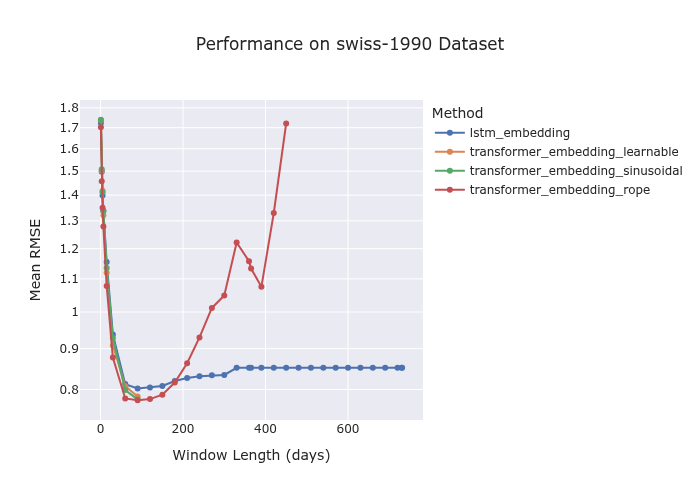

,window_len,RMSE_Mean,RMSE_Std,method
0,1,1.646352,0.653347,lstm_embedding
1,3,1.388365,0.567825,lstm_embedding
2,5,1.284572,0.522987,lstm_embedding
3,7,1.215106,0.482741,lstm_embedding
4,15,1.042723,0.373574,lstm_embedding
...,...,...,...,...
83,365,1.319738,0.561636,transformer_embedding_rope
84,390,1.146972,0.388649,transformer_embedding_rope
85,420,1.560546,0.531024,transformer_embedding_rope
86,450,NaN,0.935011,transformer_embedding_rope


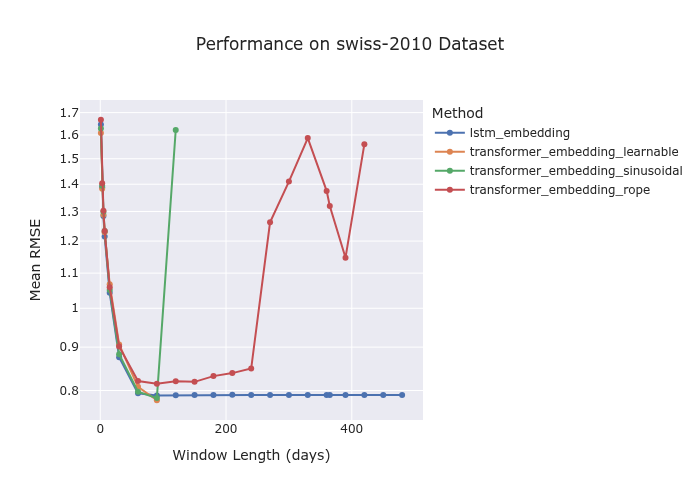

,window_len,RMSE_Mean,RMSE_Std,method
0,1,2.017828,0.633028,lstm_embedding
1,3,1.640240,0.571803,lstm_embedding
2,5,1.471816,0.490080,lstm_embedding
3,7,1.355394,0.432829,lstm_embedding
4,15,1.126012,0.310979,lstm_embedding
...,...,...,...,...
83,365,1.057460,0.150861,transformer_embedding_rope
84,390,1.164066,0.141259,transformer_embedding_rope
85,420,1.410749,0.194261,transformer_embedding_rope
86,450,1.753814,0.274192,transformer_embedding_rope


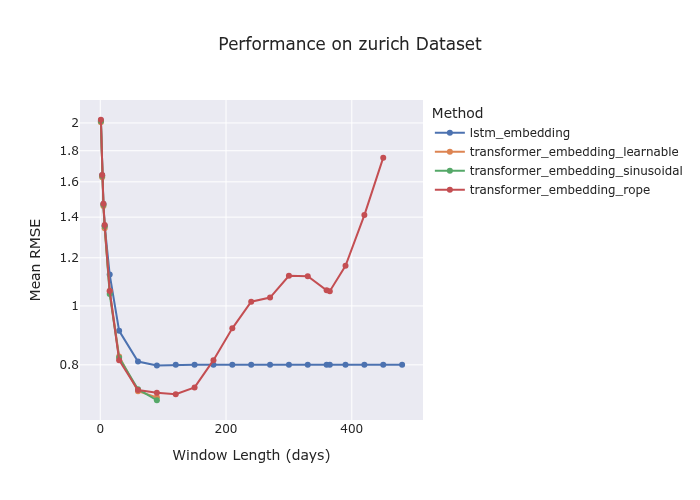

In [28]:
# Plot results from CSV using Plotly (interactive in Jupyter Notebook):

%matplotlib inline


from pathlib import Path
import plotly.io as pio
from IPython.display import Image, display

# Set up Plotly template similar to Seaborn style:
print(pio.templates)
pio.templates.default = "seaborn"

# -----------------------
# Plotting function
# -----------------------


import plotly.express as px


def plot_results_from_csv_plotly(
        dump_dir: Path, graph_name: str, methods: list,
        xlog=False, ylog=False, if_interactive: bool | str = 'both',
        if_trim_overflows: bool = True,
):
    import pandas as pd

    # Merge all methods' data into a single DataFrame for plotting:
    df_all = pd.DataFrame()
    for m in methods:
        df_resu = gather_results(dump_dir, graph_name, m)
        df_all = pd.concat([df_all, df_resu], ignore_index=True)

    if df_all.empty:
        print(f"{ISSUE_TAG} No valid data to plot for graph='{graph_name}'.")
        return

    if if_trim_overflows:
        df_all = trim_overflows(df_all, base='win_len_1')

    display(df_all)

    fig = px.line(
        df_all, x='window_len', y='RMSE_Mean', color='method',
        markers=True,
        log_x=xlog,
        log_y=ylog,
        template='seaborn',
        title=f'Performance on {graph_name} Dataset',
        labels={'window_len': 'Window Length (days)', 'RMSE_Mean': 'Mean RMSE', 'method': 'Method'}
    )

    fig.update_layout(hovermode='x unified')

    if str(if_interactive).lower() in ['true', 'both']:
        fig.show()

    if str(if_interactive).lower() in ['false', 'both']:
        # Plotly generates interactive HTML by default, which can not be shown in static platforms like GitHub.
        # Here we convert the figure to a static PNG image for display.
        png_bytes = pio.to_image(fig, format='png')
        display(Image(png_bytes))


for graph_name in GRAPH_NAMES[0:]:
    print()
    print(f'{INFO_TAG} ================= Plotting results for graph="{graph_name}" =================')
    plot_results_from_csv_plotly(
        DUMP_DIR, graph_name, METHODS[4:6],
        xlog=False, ylog=True,
        if_interactive='both', if_trim_overflows=True
    )

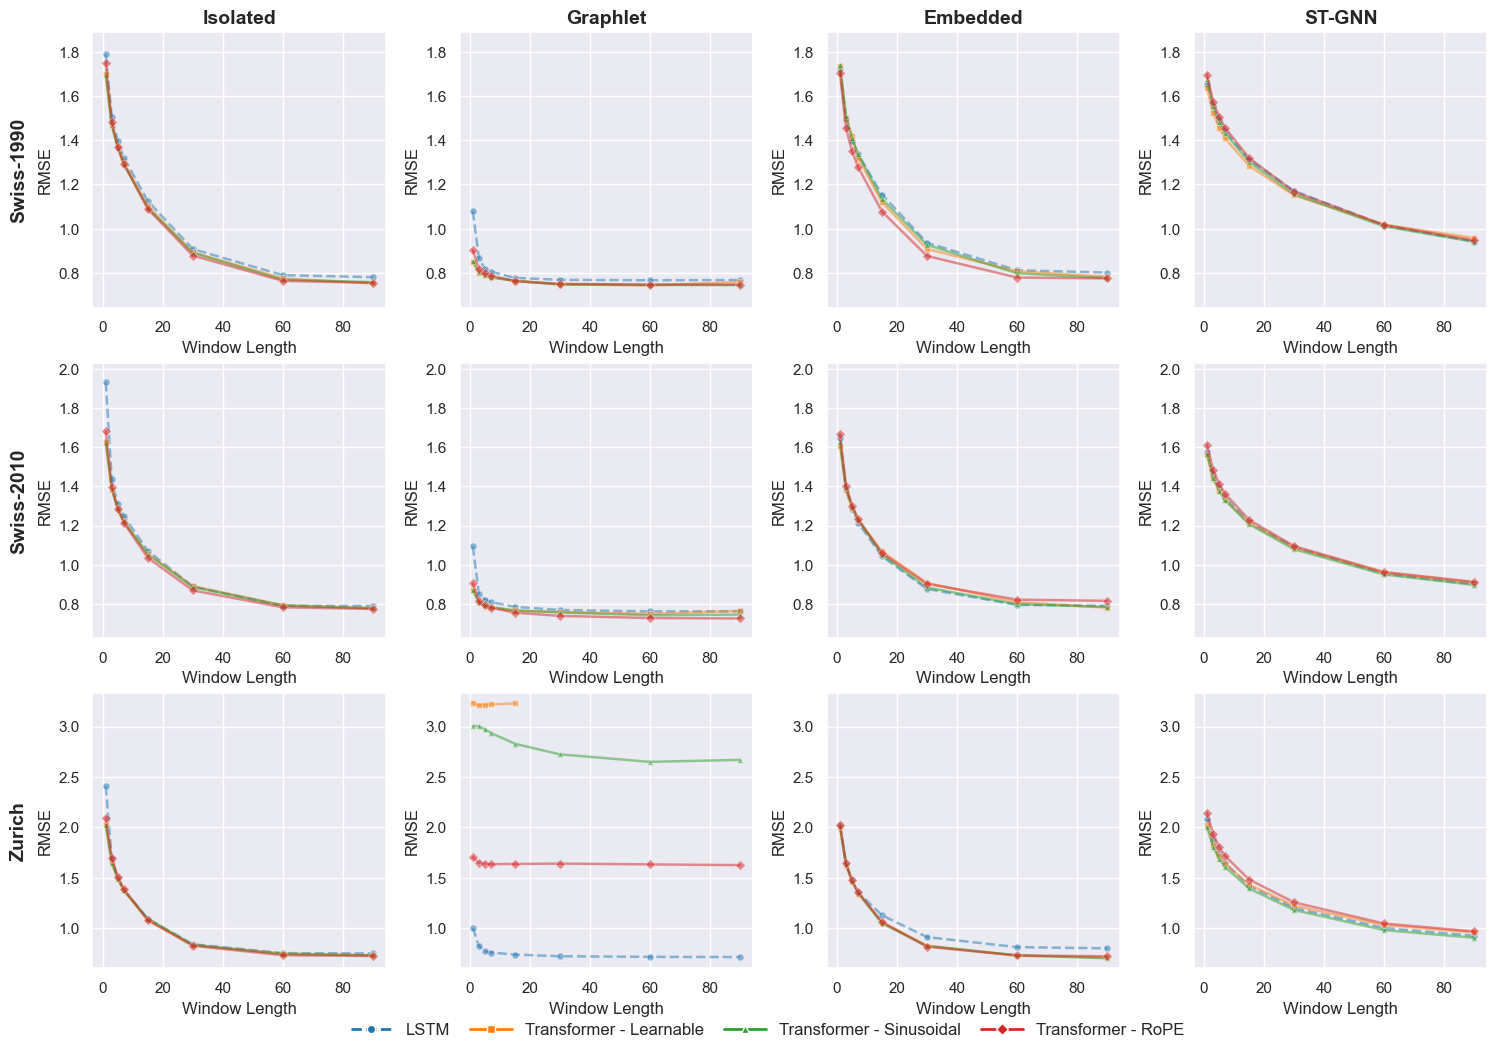

Button(button_style='success', description='Open in File Manager', style=ButtonStyle())

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

sns.set_theme()  # style="whitegrid", font_scale=1.2)


def gather_results_for_grid_plot(
        dump_dir: Path, graph_name: str, method_with_pe: str,
) -> pd.DataFrame:
    if is_transformer_model(method_with_pe):
        method_split = method_with_pe.split('_')
        base_method = '_'.join(method_split[0:-1])  # Remove positional encoding
        pe = method_split[-1]
        df_all = gather_results(dump_dir, graph_name, base_method)
        if df_all.empty:
            return df_all
        # Filter for the specific positional encoding:
        df_all = df_all[df_all['method'] == f'{base_method}_{pe}']
        return df_all
    else:
        base_method = method_with_pe
        return gather_results(dump_dir, graph_name, base_method)


def plot_results_grid(
        dump_dir, datasets, method_groups, figsize=(18, 12),
        xlog: bool = False, ylog: bool = False,
        x_range: list | None = None,
        if_trim_overflows: bool = True
):
    rows = len(datasets)
    cols = len(method_groups)

    fig, axes = plt.subplots(rows, cols, figsize=figsize, sharex=False)
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    if rows == 1:
        axes = np.array([axes])
    if cols == 1:
        axes = axes[:, np.newaxis]

    # Colors:
    palette = sns.color_palette("tab10", n_colors=10)
    colors = palette.as_hex()[0:len(next(iter(method_groups.values())))]
    # colors = ['#FF4500', '#FFB000']
    # colors = ['#F77F00', '#D62828']

    line_styles = ['--', '-', '-', '-']
    scatter_markers = ['o', 's', '^', 'D']

    # per-row y-range:
    ymin = [np.inf] * rows
    ymax = [-np.inf] * rows

    # Store all trace to unify y-limit at the end:
    trace_store = {}  # (r,c) -> list of draws

    # ---- Collect y values and plot: ----
    for r, dataset_name in enumerate(datasets):
        for c, (model_class, method_list) in enumerate(method_groups.items()):

            ax = axes[r, c]

            # gather all results
            df_all = pd.DataFrame()
            for m in method_list:
                df_resu = gather_results_for_grid_plot(dump_dir, dataset_name, m)
                df_all = pd.concat([df_all, df_resu], ignore_index=True)

            if df_all.empty:
                # ax.set_title(f"{dataset_name} - {model_class}\n(No data)")
                continue

            if if_trim_overflows:
                df_all = trim_overflows(df_all, base='win_len_1')

            # plot each method:
            trace_store[(r, c)] = []
            for mid, method_name in enumerate(method_list):
                df_sub = df_all[df_all['method'] == method_name]

                x = df_sub["window_len"]
                y = df_sub["RMSE_Mean"]

                if x_range is not None:
                    idx_x = np.searchsorted(x, x_range)
                    x = x.iloc[idx_x]
                    y = y.iloc[idx_x]

                # Plot line with markers:
                line = ax.plot(
                    x, y,
                    label=method_name,
                    color=colors[mid],
                    linestyle=line_styles[mid],
                    marker=scatter_markers[mid],
                    markersize=5,
                    markeredgecolor='white',
                    markeredgewidth=0.5,
                    linewidth=1.8,
                    alpha=0.5,
                )
                trace_store[(r, c)].append((x, y))

                # shaded mean ± std:
                if "RMSE_Std" in df_sub.columns:
                    upper, lower = y, y
                    # upper = y + df_sub["RMSE_Std"]
                    # lower = y - df_sub["RMSE_Std"]
                    # ax.fill_between(
                    #     x, lower, upper,
                    #     color=palette[mid], alpha=0.15
                    # )
                    # trace_store[(r, c)].append((x, upper))
                    # trace_store[(r, c)].append((x, lower))
                else:
                    upper, lower = y, y

                # Update per-row y-range
                ymin[r] = max(0, min(ymin[r], y.min() - 0.1, lower.min() - 0.1))
                ymax[r] = max(ymax[r], y.max() + 0.1, upper.max() + 0.1)

            ax.set_xlabel("Window Length")
            ax.set_ylabel("RMSE")
            ax.set_xscale('log' if xlog else 'linear')
            ax.set_yscale('log' if ylog else 'linear')

    # ---- Use the same y-range per row: ----
    for r in range(rows):
        for c in range(cols):
            ax = axes[r, c]
            ax.set_ylim(ymin[r], ymax[r])

    col_labels = ['Isolated', 'Graphlet', 'Embedded', 'ST-GNN']
    for col_idx, col_label in enumerate(col_labels):
        axes[0, col_idx].text(
            0.5, 1.05, col_label,
            transform=axes[0, col_idx].transAxes,
            ha='center', va='center',
            fontsize=14, weight='bold'
        )

    row_labels = ['Swiss-1990', 'Swiss-2010', 'Zurich']
    for row_idx, row_label in enumerate(row_labels):
        axes[row_idx, 0].text(
            -0.25, 0.5, row_label,
            transform=axes[row_idx, 0].transAxes,
            ha='center', va='center',
            rotation=90,
            fontsize=14, weight='bold'
        )

    # Add legend relative to bottom-center of figure:
    plt.subplots_adjust(bottom=0.07)
    labels = ('LSTM', 'Transformer - Learnable', 'Transformer - Sinusoidal', 'Transformer - RoPE')
    legend_elements = [
        Line2D(
            [0], [0], color=color, lw=2, linestyle=line_style,
            marker=scatter_marker, markersize=6, markerfacecolor=color,
            markeredgecolor='w', label=label
        )
        for color, line_style, scatter_marker, label in zip(colors, line_styles, scatter_markers, labels)
    ]
    legend = fig.legend(
        handles=legend_elements,
        # labels,
        loc='lower center',
        bbox_to_anchor=(0.5, 0),
        ncol=len(legend_elements),
        fontsize='medium',
        frameon=False,
        handlelength=2.5,
        columnspacing=1.2,
    )

    # plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Save figure:
    output_path = CUR_ABS_DIR / 'figures' / 'window_length_grid_plot.pdf'
    output_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_path, dpi=300, bbox_inches='tight')
    from swissrivernetwork.util.os import make_open_button

    print(f'{SUCCESS_TAG}Saved grid plot to {output_path}.')
    make_open_button(output_path)


# ---------------------------------------------------------
# Plot calls
# ---------------------------------------------------------

positional_encodings = ['learnable', 'sinusoidal', 'rope']
method_groups = {
    "Isolated": ['lstm'] + [f'transformer_{pe}' for pe in positional_encodings],
    "Graphlet": ['graphlet'] + [f'transformer_graphlet_{pe}' for pe in positional_encodings],
    "Embedded": ['lstm_embedding'] + [f'transformer_embedding_{pe}' for pe in positional_encodings],
    "ST-GNN": ['stgnn'] + [f'transformer_stgnn_{pe}' for pe in positional_encodings],
}

plot_results_grid(
    DUMP_DIR,
    datasets=GRAPH_NAMES[0:3],
    method_groups=method_groups,
    xlog=False,
    ylog=False,
    x_range=WINDOW_LENS,
    if_trim_overflows=True,
)
